# Spis treści

## 1. Wstęp
W tej pracy użyty został algorytm lasu losowego (ang. Random Forest) w celu dokonania klasyfikacji. Dane użyte w tej pracy, do trenowania i testowania algorytmu to obrazy przedstawiające znaki napisane odręcznie przez człowieka.
Zbiory danych dzielą się na 3 grupy:
1. Obrazy przedstawiające liczby jedności {0-9}.
- Obrazy przedstawiające znaki wpółczesnego podstawowego alfabetu łacińskiego {A-Z} z wmieszanymi w nie ich odmian liter małych {a-z}.
- Obrazy przedstawiające znaki alfabetu Devangari (liczby i spółgłoski, bez samogłosek).

W odróżnieniu od sztucznych sieci neuronowych, algorytm lasu losowego nie uczy się na pełnych obrazach, ale na ich kompaktowej reprezentacji. Jednym z etapów tej pracy jest kompresja obrazu tj. wydobycie cech charakterystycznych, przedstawiających obraz w jak najbardziej jednoznaczny sposób przy jednoczesnej redukcji wymiarowości. W tym przypadku taką cechą jest Histogram Gradietów Zorientowanych (ang. Histogram of Oriented Gradients, HOG).

Zbiory danych przedstawiające cyfry i litery alfabetu łacińskiego pochodzą z bazy EMNIST, natomiast zbiór danych alfabetu Devangari pochodzi z Computer Vision Research Group, Nepal.

## 2 Pakiety użyte w niniejszym projekcie
1. ```!pip install emnist```
- ```!pip install matplotlib```
- ```!pip install pandas```
- ```!pip install opencv-python```
- ```!pip install scikit-learn```
- ```!pip install seaborn```

## 3. Implementacja

### 3.1 Przygotowanie

In [1]:
# matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# data transformations
import numpy as np
import pandas as pd

# directory tree
from os.path import basename, dirname
from pathlib import Path

# heatmap
import seaborn as sea

# euclidean distance
from scipy.spatial.distance import cdist

# garbage collection
import gc

# dataframe display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

# openCV
import cv2

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# emnist.zip    536MB
from emnist import list_datasets
from emnist import extract_training_samples
from emnist import extract_test_samples

### 3.2 Funkcje użytkowe

Pobiera nazwę klasy ze ścieżki do obrazu .png.

In [2]:
def get_pretty_label(label):
    return label.split('_')[-1]

Wczytuje zbiór devangari z obrazów .png znajdujących się na dysku.

In [3]:
def get_devangari_set():
    # compute paths
    files = []
    for filename in Path("Data/Images").rglob('*.png'):
        files.append(filename)
    files.sort()

    # allocate memory for images dataset
    images = np.empty( (len(files), 28, 28), dtype=np.uint8 )
    labels = []
    i = 0
    for f in files:
        im = cv2.imread(str(f), 0)
        im = np.delete(im, np.s_[0, 1, 30, 31], 0)
        im = np.delete(im, np.s_[0, 1, 30, 31], 1)
        images[i] = im
        labels.append(symbols.index(get_pretty_label(basename(dirname(str(f))))))
        i = i + 1
    return images, np.asarray(labels, dtype=np.uint8)

Funkcje opakowujące funkcje z pakietu ```emnist``` dodające możliwość wyboru zbioru danych devangari.

In [4]:
def get_training_samples(dataset):
    if dataset == "devangari":
        images, labels = get_devangari_set()
        split = 0.3
        x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=split)
        return x_train, y_train
    else:
        return extract_training_samples(dataset)

def get_test_samples(dataset):
    if dataset == "devangari":
        images, labels = get_devangari_set()
        split = 0.3
        x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=split)
        return x_test, y_test
    else:
        return extract_test_samples(dataset)

Funkcja zwracająca listę deskryptorów. Wyliczenie parametrów owych deskrpytporów nie było proste, algorytm wymaga dokładnej definicji swojego zachowania, a jego parametry mają bardzo dużo możliwości, natomiast tylko niektóre kombinacje mają sens. Potrzebna jest duża doza poznania tego algorytmu w celu jego nawet podstawowego użycia.

#### Opis najważniejszych parametrów algorytmu HOG:
- <b>winSize</b>: Okno, w którym ma znajdować się obiekt, który będzie klasyfikowany, w tym przypadku znak jest wyodrębniony i poświęcony jest mu cały obraz więc okna ma rozmiar obrazu.
- <b>blockSize</b>: Ten parametr służy do normalizacji wartości pikseli w celu uniewrażliwienia modeli na zjawisko iluminacji, w tym przypadku takie zjawisko nie zachodzi, więc parametr ma taką samą wartość jak cellSize. Blok składa się z komórek, które definijue parametr cellSize.
- <b>cellSize</b>: Ilość pikseli, na które składa się komórka, tak więc kontroluje ilość cech jakie produkuje algorytm, im mniejsza ilośc pikseli tym większa ilość cech.
- <b>blockStride</b>: Opisuje wartość nachodzenia się bloków na siebie.
- <b>nbins</b>: Kubełki histogramu, określają w ilu orientacjach mają być wyliczane gradienty. Im więcej orientacji tym bardziej szczegółowy opis obrazu.
- <b>useSignedGradients</b>: Niesie informację czy algorytm będzie wyliczać gradienty w zakresie 180' czy 360'. Zazwyczaj orientacja 180' wystarcza, natomiast w tej pracy używane są orientacje z zakresu 360', gdyż dają odrobinę lepsze rezultaty.

In [5]:
def get_hogs(hog_params):
    winSize = (28, 28)
    derivAperture = 1
    winSigma = -1
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    useSignedGradients = True

    hogs = []
    for index, row in hog_params.iterrows():
        blockSize = (row['block_size'], row['block_size'])
        cellSize = (row['block_size'], row['block_size'])
        blockStride = (row['block_stride'], row['block_stride'])
        nbins = row['bins']
        
        hog = cv2.HOGDescriptor(winSize,blockSize,
                                blockStride,cellSize,
                                nbins,derivAperture,
                                winSigma,histogramNormType,
                                L2HysThreshold,gammaCorrection,
                                nlevels, useSignedGradients)
        hogs.append(hog)
    return hogs

Funkcja trenująca i testująca model lasu losowego dla każdego algorytmu HOG.

In [6]:
def train_test(hogs, train_imgs, train_labels, test_imgs, test_labels, ntrees=range(1, 6), cores=-1):
    # define statistics variables
    block_size = []
    block_stride = []
    nBins = []
    nTrees = []
    accuracy = []
    predictions = []

    # for each hog compute descriptors
    #     for each number of trees train test model
    for hog in hogs:
        # get descriptors for training
        train_descriptor = []
        for img in train_imgs:
            hist = hog.compute(img)
            train_descriptor.append(hist.flatten())
        # get descriptor for testing
        test_descriptor = []
        for img in test_imgs:
            hist = hog.compute(img)
            test_descriptor.append(hist.flatten())
        # train test models
        for trees in ntrees:
            # instatiate
            rf = RandomForestClassifier(n_estimators=trees, n_jobs=cores)
            # train
            rf.fit(train_descriptor, train_labels)
            # test
            predicted = rf.predict(test_descriptor)
            # gather statistics
            block_size.append(hog.blockSize[0])
            block_stride.append(hog.blockStride[0])
            nBins.append(hog.nbins)
            nTrees.append(trees)
            accuracy.append(accuracy_score(predicted, test_labels))
            predictions.append(predicted)
    # aggregate to data frame
    d = dict(block_size=block_size, block_stride=block_stride, nBins=nBins, nTrees=nTrees, accuracy=accuracy, predictions=predictions)
    results = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
    
    return results

Funkcja rysująca mapę, która jest ładniejszą i czytelniejszą reprezentacją macierzy kontyngecji. Ma na celu przedstawienie w bardziej szczegółowy sposób wyników klasyfikacji.

In [7]:
def plot_heatmap(rows, cols, dataset, title="Contingency table", figsize=(15, 12), cmap='inferno', fontsize=20):
    # ASCII code maped to upper case letters
    letters = ['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    ct = pd.crosstab(rows, cols)
    if dataset == 'letters':
        ct.columns = letters[1::]
        ct.index = letters[1::]
    elif dataset == 'devangari':
        ct.columns = symbols[1::]
        ct.index = symbols[1::]
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    sea.heatmap(ct, annot=True, ax=ax, fmt='g', cmap=cmap)

Funkcje wczytujące zbiory danych do ramki danych. Ma to na celu ułatwienie eksploracji zbiorów.

In [8]:
def get_training_samples_dataframe(dataset):
    if dataset not in ['letters', 'digits', 'devangari']:
        return None

    flag = False
    if dataset == 'letters':
        flag = True

    # ASCII code maped to upper case letters
    letters = ['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    
    columns = np.arange(0, 784).tolist()
    columns.extend(['label'])
    images, labels = get_training_samples(dataset)
    rows = []
    for i in range(0, len(images)):
        r = images[i].reshape(784).tolist()
        if flag:
            r.append(letters[labels[i]])
        else:
            r.append(labels[i])
        rows.append(r)
    return pd.DataFrame(rows, columns=columns)

def get_test_samples_dataframe(dataset):
    if dataset not in ['letters', 'digits', 'devangari']:
        return None

    flag = False
    if dataset == 'letters':
        flag = True

    # ASCII code maped to upper case letters
    letters = ['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    
    columns = np.arange(0, 784).tolist()
    columns.extend(['label'])
    images, labels = get_test_samples(dataset)
    rows = []
    for i in range(0, len(images)):
        r = images[i].reshape(784).tolist()
        if flag:
            r.append(letters[labels[i]])
        else:
            r.append(labels[i])
        rows.append(r)
    return pd.DataFrame(rows, columns=columns)

Funckcja obliczająca odległość euklidesową każdej obserwacji od średniej obserwacji. Wykorzystywana przy wynajdywaniu obserwacji nietypowych.

In [9]:
def euclidean_dist(frame, mean, dataset):
    distance = []
    for i in range(0, len(frame)):
        elem = np.asarray(frame.iloc[i,:784].values.reshape(28, 28), dtype=np.uint8)
        label = []
        if dataset == 'letters':
            label = letters.index(frame.iloc[i - 1, 784]) - 1
        if dataset == 'digits':
            label = frame.iloc[i, 784]
        if dataset == 'devangari':
            label = frame.iloc[i, 784]
        m = np.asarray(mean.iloc[label - 1, :].values.reshape(28, 28), dtype=np.uint8)
        distance.append(cv2.norm(m, elem))
    return distance

Globalnie zdefiniowane parametry algorytmu HOG, skrupulatnie wcześniej opisane i wyliczone.

In [10]:
# data frame of HOG params
# blockSize   blockStride   nbins
hog_params = pd.DataFrame(data={'block_size':   [4, 4, 4, 4, 8, 8, 10, 10, 12, 12, 12, 12, 14, 14, 16, 16, 16, 16],
                              'block_stride':  [2, 2, 3, 3, 4, 4, 9,  9,  4,  4,  8,  8,  7,  7,  4,  4,  12, 12],
                              'bins':          [4, 9, 4, 9, 4, 9, 4,  9,  4,  9,  4,  9,  4,  9,  4,  9,  4,  9 ]},
                         dtype=np.uint8)
hog_params

block_size  block_stride  bins
0            4             2     4
1            4             2     9
2            4             3     4
3            4             3     9
4            8             4     4
5            8             4     9
6           10             9     4
7           10             9     9
8           12             4     4
9           12             4     9
10          12             8     4
11          12             8     9
12          14             7     4
13          14             7     9
14          16             4     4
15          16             4     9
16          16            12     4
17          16            12     9

Przydatna zmienna dla zbioru ze znakami alfabetu łacińskiego.

In [11]:
# ASCII code maped to upper case letters
letters = ['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [12]:
# Devangari symbols
symbols = ['', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'adna', 'ba', 'bha', 'cha', 'chha', 'chhya', 'da', 'daa', 'dha', 'dhaa', 'ga', 'gha', 'gya', 'ha', 'ja', 'jha', 'ka', 'kha', 'kna', 'la', 'ma', 'motosaw', 'na', 'pa', 'patalosaw', 'petchiryakha', 'pha', 'ra', 'taamatar', 'tabala', 'tha', 'thaa', 'tra', 'waw', 'yaw', 'yna']

### 3.3 Eksploracja zbioru liczb

Obrazy składają się z 784 pikseli (28 x 28). W zbiorze testowym znajduje się 240 000 obserwacji.

In [13]:
digits_frame = get_training_samples_dataframe('digits')
digits_frame

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  ...  770  771  772  \
0       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
1       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
2       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
3       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
4       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
...    .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   
239995  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
239996  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
239997  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
239998  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
239999  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   

        773  774  775  776  777  778  779  780  781  782  783  label  
0         0    0    0    0    0    0    0    0    0    0    0      8  
1         0    0    0    0    0    0    0    0    0    0    0      9  
2         0    0    0    0    0    0    0    0    0    0    0      6  
3         0    0    0    0    0    0    0    0    0    0    0      3  
4         0    0    0    0    0    0    0    0    0    0    0      6  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...  
239995    0    0    0    0    0    0    0    0    0    0    0      4  
239996    0    0    0    0    0    0    0    0    0    0    0      2  
239997    0    0    0    0    0    0    0    0    0    0    0      1  
239998    0    0    0    0    0    0    0    0    0    0    0      1  
239999    0    0    0    0    0    0    0    0    0    0    0      0  

[240000 rows x 785 columns]

Widać, że większość pikseli jest czarna lub biała, z ogromną przewagą pikseli czarnych bardzo niewiele jest wartości pomiędzy. Można by na bazie tego przeprowadzić binaryzację obrazów i nie stracić przy tym zbyt wielu informacji.

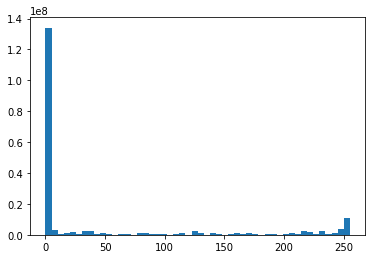

In [14]:
plt.hist(digits_frame.values[0:240000, 0:784].flatten(), bins=50)
plt.show()

In [15]:
mean_digits = digits_frame.groupby('label').mean()
mean_digits

0    1    2    3    4    5    6    7    8    9    10   11   12   13   \
label                                                                         
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       14   ...  769  770  771  772  773  774  775  776  777  778  779  780  \
label       ...                                                               
0      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9      0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       781  782  783  
label                 
0      0.0  0.0  0.0  
1      0.0  0.0  0.0  
2      0.0  0.0  0.0  
3      0.0  0.0  0.0  
4      0.0  0.0  0.0  
5      0.0  0.0  0.0  
6      0.0  0.0  0.0  
7      0.0  0.0  0.0  
8      0.0  0.0  0.0  
9      0.0  0.0  0.0  

[10 rows x 784 columns]

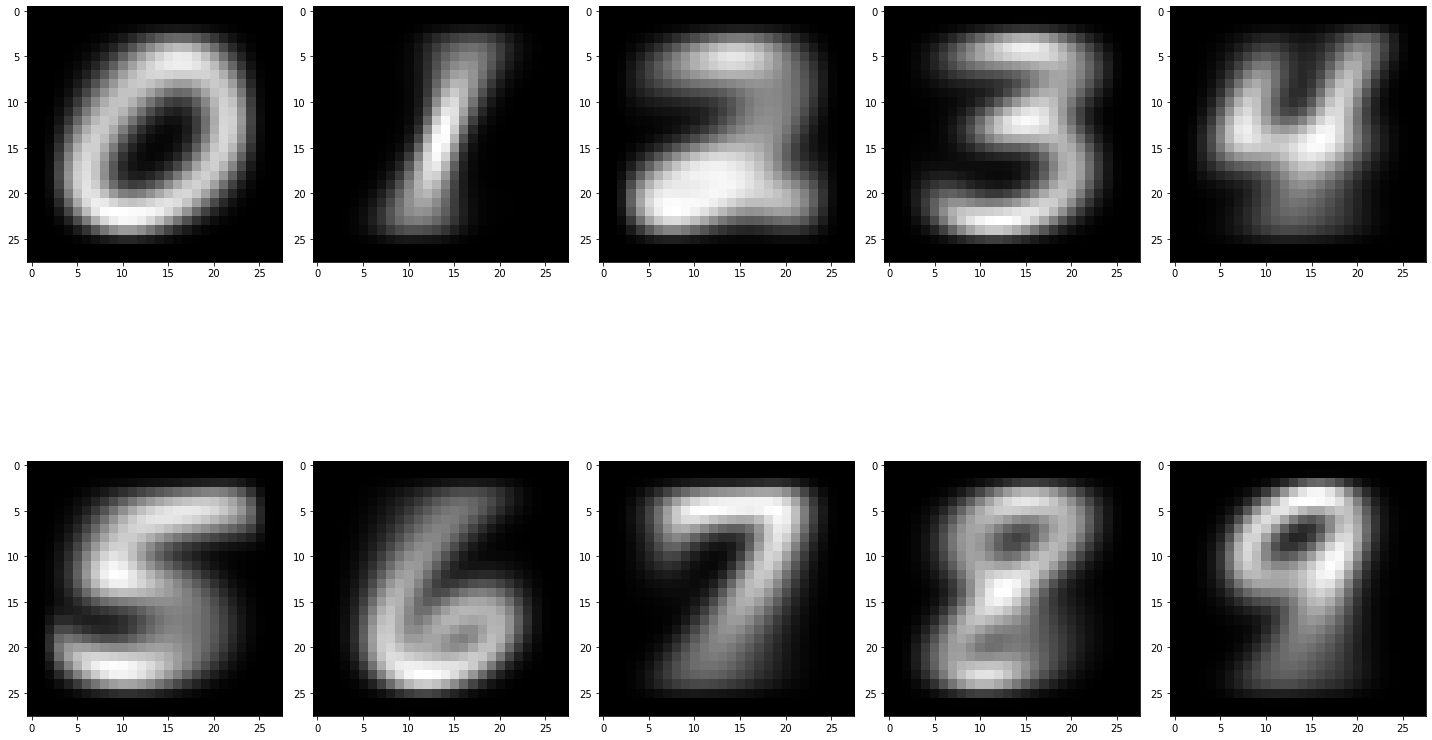

In [16]:
f = plt.figure(figsize=(20, 15))
for i in range(0, 10):
    ax = f.add_subplot(2, 5, i + 1)
    ax.imshow(mean_digits.values[i].reshape(28, 28), cmap='gray')
plt.tight_layout()

Powyżej widać uśrednione obserwacje. Obrazy te zostały wyliczone uśredniając odpowiadające sobie poksele w obrazach ze zbioru treningowego.
Można zobserwować, że liczba zero ma bardzo niewielkie zróżnicowane. Co ciekawe, 'ogonki' i niektóre zaokrąglenia liczb charakteryzują się największym zróżnicowaniem, czyli są to miejsca, w których pismo jest najbardziej frywolne i ujawnia swoją osobliwość. Ciekawe jak wyglądają liczby najbardziej odległe od tych uśrednionych.

In [17]:
dists_digits = euclidean_dist(frame=digits_frame, mean=mean_digits, dataset='digits')
digits_frame['distance'] = dists_digits

In [18]:
digits_frame

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  ...  771  772  773  \
0       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
1       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
2       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
3       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
4       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
...    .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   
239995  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
239996  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
239997  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
239998  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
239999  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   

        774  775  776  777  778  779  780  781  782  783  label     distance  
0         0    0    0    0    0    0    0    0    0    0      8  2218.279513  
1         0    0    0    0    0    0    0    0    0    0      9  1922.826305  
2         0    0    0    0    0    0    0    0    0    0      6  1794.053511  
3         0    0    0    0    0    0    0    0    0    0      3  2304.495389  
4         0    0    0    0    0    0    0    0    0    0      6  2127.764085  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...          ...  
239995    0    0    0    0    0    0    0    0    0    0      4  2155.895638  
239996    0    0    0    0    0    0    0    0    0    0      2  2340.732150  
239997    0    0    0    0    0    0    0    0    0    0      1  2376.263874  
239998    0    0    0    0    0    0    0    0    0    0      1  2312.953739  
239999    0    0    0    0    0    0    0    0    0    0      0  2438.977245  

[240000 rows x 786 columns]

In [19]:
atypical_digits = digits_frame.sort_values('distance', ascending=False, kind='mergesort').groupby('label').first()
atypical_digits

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  ...  770  771  772  \
label                                                    ...                  
0      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
1      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
2      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
3      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
4      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
5      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
6      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
7      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
8      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
9      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   

       773  774  775  776  777  778  779  780  781  782  783     distance  
label                                                                      
0        0    0    0    0    0    0    0    0    0    0    0  3639.974863  
1        0    0    0    0    0    0    0    0    0    0    0  2854.335649  
2        0    0    0    0    0    0    0    0    0    0    0  3782.749793  
3        0    0    0    0    0    0    0    0    0    0    0  3142.902957  
4        0    0    0    0    0    0    0    0    0    0    0  3315.319743  
5        0    0    0    0    0    0    0    0    0    0    0  3259.898925  
6        0    0    0    0    0    0    0    0    0    0    0  3189.138755  
7        0    0    0    0    0    0    0    0    0    0    0  3445.476019  
8        0    0    0    0    0    0    0    0    0    0    0  3515.331848  
9        0    0    0    0    0    0    0    0    0    0    0  3093.698757  

[10 rows x 785 columns]

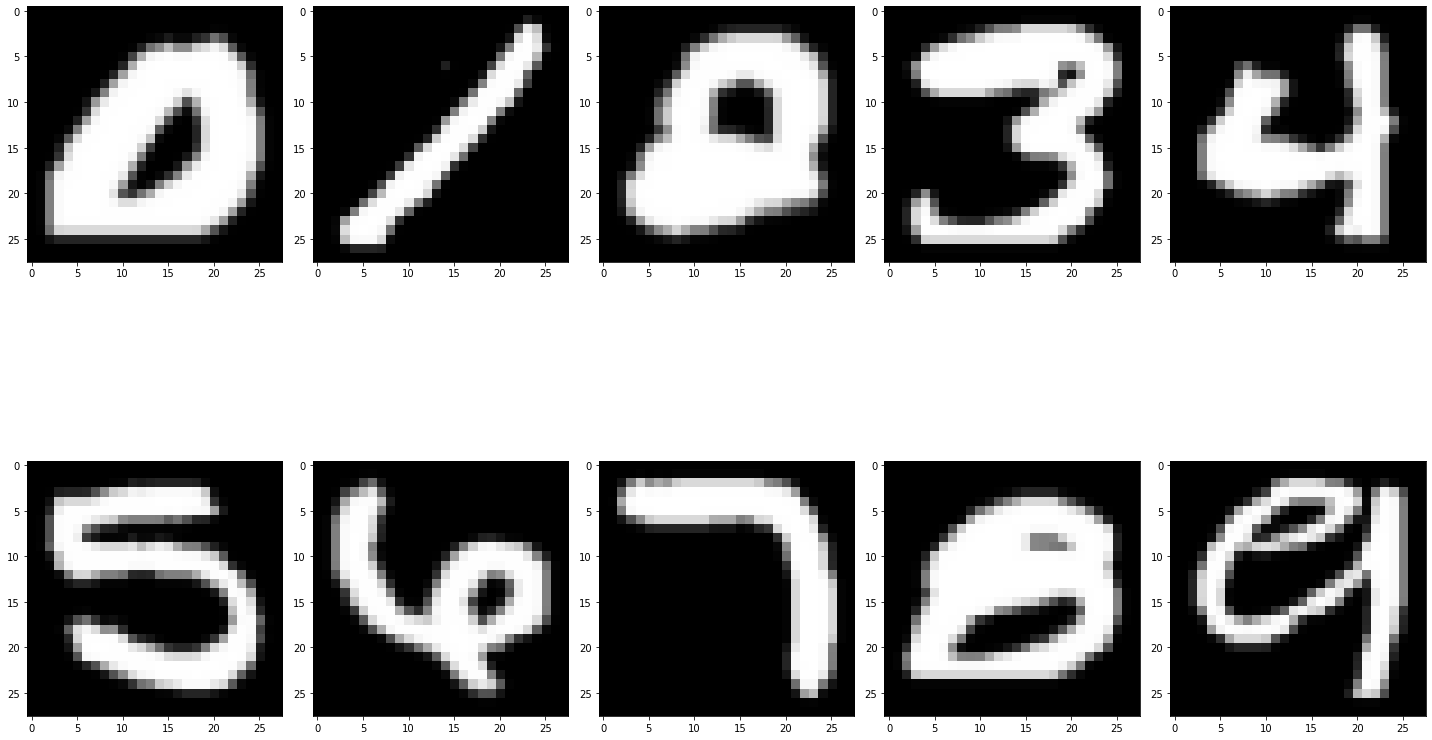

In [20]:
f = plt.figure(figsize=(20, 15))
for i in range(0, 10):
    ax1 = f.add_subplot(2, 5, i + 1)
    ax1.imshow(atypical_digits.values[i][:784].reshape(28, 28), cmap='gray')
plt.tight_layout()

Niektóre z tych wartości atypowych są trudne do rozpoznania anwet przez człowieka, np. 0, 2 i 8 wyglądają podobnie, 1 jest ukośne, 7 jest zgiętą linią, która kształtem nie przypomina cyfry 7, natomiast 9 ma dodatkową pętlę w sobie co może być zmyłką dla algorytmu HOG. Wnisek z tego jest taki, że nie możemy się spodziewać za dużo od modelu, ponieważ rozpoznanie takich przypadków jest wyjątkowo trudne, o ile w ogóle możliwe lub sensowne.

In [21]:
del digits_frame
del mean_digits
del atypical_digits
del dists_digits
gc.collect()
len(gc.get_objects())

188509

### 3.4 Wyniki

In [22]:
hogs = get_hogs(hog_params)

In [23]:
train_digits, train_digits_labels = get_training_samples('digits')
test_digits, test_digits_labels = get_test_samples('digits')

In [24]:
# 10 - 20 min depending on machine
# avg 12 min
digits_results = train_test(hogs=hogs, 
                            train_imgs=train_digits, 
                            train_labels=train_digits_labels, 
                            test_imgs=test_digits, 
                            test_labels=test_digits_labels)

Dla zbioru liczb modele wytrenowały się ogólnie dobrze, dla większości parametrów. Widać, że większa ilość orientacji gradientów daje większą skuteczność modelu.

In [25]:
digits_results

block_size  block_stride  nBins  nTrees  accuracy  \
0            4             2      4       1  0.884075   
1            4             2      4       2  0.891475   
2            4             2      4       3  0.932425   
3            4             2      4       4  0.947000   
4            4             2      4       5  0.952600   
5            4             2      9       1  0.912125   
6            4             2      9       2  0.911800   
7            4             2      9       3  0.951000   
8            4             2      9       4  0.964325   
9            4             2      9       5  0.969050   
10           4             3      4       1  0.878825   
11           4             3      4       2  0.881275   
12           4             3      4       3  0.928675   
13           4             3      4       4  0.942900   
14           4             3      4       5  0.951550   
15           4             3      9       1  0.901575   
16           4             3      9       2  0.902450   
17           4             3      9       3  0.946750   
18           4             3      9       4  0.960900   
19           4             3      9       5  0.966500   
20           8             4      4       1  0.891200   
21           8             4      4       2  0.888325   
22           8             4      4       3  0.932125   
23           8             4      4       4  0.944875   
24           8             4      4       5  0.951575   
25           8             4      9       1  0.932550   
26           8             4      9       2  0.930950   
27           8             4      9       3  0.963275   
28           8             4      9       4  0.971925   
29           8             4      9       5  0.977425   
30          10             9      4       1  0.824500   
31          10             9      4       2  0.825800   
32          10             9      4       3  0.870175   
33          10             9      4       4  0.886100   
34          10             9      4       5  0.895325   
35          10             9      9       1  0.917425   
36          10             9      9       2  0.916750   
37          10             9      9       3  0.948650   
38          10             9      9       4  0.959825   
39          10             9      9       5  0.965800   
40          12             4      4       1  0.872875   
41          12             4      4       2  0.880700   
42          12             4      4       3  0.917450   
43          12             4      4       4  0.933100   
44          12             4      4       5  0.940300   
45          12             4      9       1  0.935825   
46          12             4      9       2  0.941525   
47          12             4      9       3  0.967850   
48          12             4      9       4  0.974700   
49          12             4      9       5  0.978650   
50          12             8      4       1  0.831250   
51          12             8      4       2  0.840775   
52          12             8      4       3  0.878250   
53          12             8      4       4  0.893425   
54          12             8      4       5  0.902450   
55          12             8      9       1  0.925950   
56          12             8      9       2  0.928100   
57          12             8      9       3  0.960225   
58          12             8      9       4  0.967300   
59          12             8      9       5  0.974500   
60          14             7      4       1  0.819225   
61          14             7      4       2  0.829725   
62          14             7      4       3  0.870625   
63          14             7      4       4  0.881450   
64          14             7      4       5  0.890500   
65          14             7      9       1  0.931150   
66          14             7      9       2  0.928525   
67          14             7      9       3  0.960125   
68          14             7      9       4  0.968875   
69          14

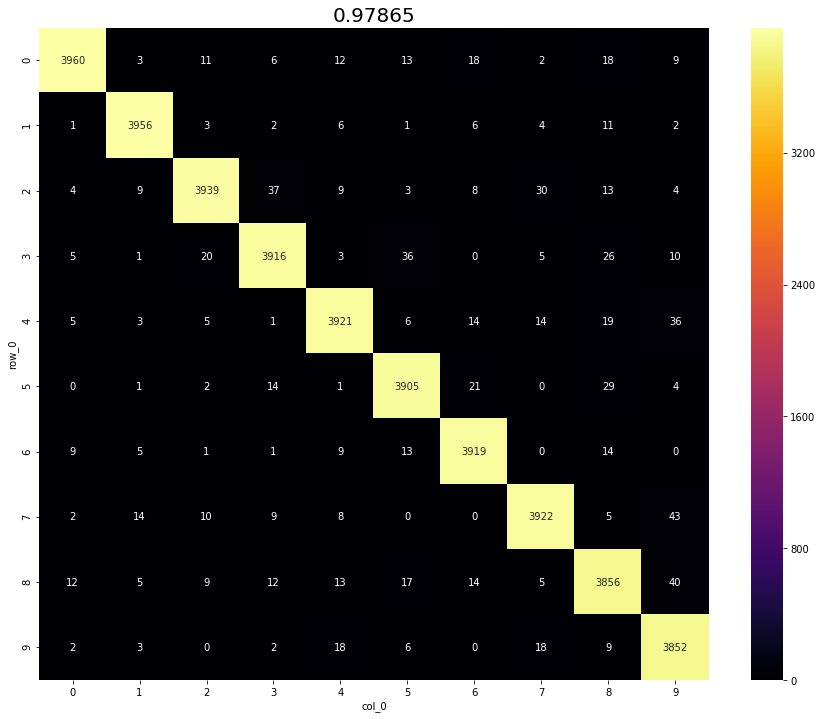

In [26]:
best_digits_model = digits_results.loc[digits_results['accuracy'].idxmax()]
plot_heatmap(rows = best_digits_model.predictions,
             cols = test_digits_labels,
             title = best_digits_model['accuracy'],
             dataset = 'digits')

Najlepszemu modelowi najczęściej myliły się 2 z 3, 7 z 9, 8 z 9, 4 z 9 i 3 z 5.

In [27]:
del digits_results
del best_digits_model
del hogs
gc.collect()
len(gc.get_objects())

188583

### 3.5 Eksploracja zbioru liter

Obrazy składają się z 784 pikseli (28 x 28). W zbiorze testowym znajduje się 124 800 obserwaji.

In [28]:
letters_frame = get_training_samples_dataframe('letters')
letters_frame

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  ...  770  771  772  \
0       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
1       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
2       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
3       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
4       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
...    .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   
124795  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
124796  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
124797  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
124798  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
124799  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   

        773  774  775  776  777  778  779  780  781  782  783  label  
0         0    0    0    0    0    0    0    0    0    0    0      W  
1         0    0    0    0    0    0    0    0    0    0    0      G  
2         0    0    0    0    0    0    0    0    0    0    0      P  
3         0    0    0    0    0    0    0    0    0    0    0      O  
4         0    0    0    0    0    0    0    0    0    0    0      W  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...  
124795    0    0    0    0    0    0    0    0    0    0    0      B  
124796    0    0    0    0    0    0    0    0    0    0    0      R  
124797    0    0    0    0    0    0    0    0    0    0    0      M  
124798    0    0    0    0    0    0    0    0    0    0    0      O  
124799    0    0    0    0    0    0    0    0    0    0    0      S  

[124800 rows x 785 columns]

Sytuacja wygląda bardzo podobnie jak w przypadku zbioru liczb, jest wyraźna przewaga pikseli czarnych i białych, wartości pomiędzy jest niewiele.

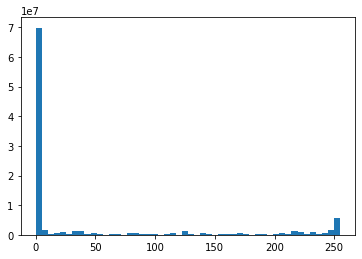

In [29]:
plt.hist(letters_frame.values[0:124800, 0:784].flatten(), bins=50)
plt.show()

In [30]:
mean_letters = letters_frame.groupby('label').mean()
mean_letters

0    1    2    3         4        5         6         7         8    \
label                                                                        
A      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
B      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
C      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
D      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
E      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
F      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
G      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
H      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
I      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
J      0.0  0.0  0.0  0.0  0.000208  0.02625  0.051875  0.052083  0.043333   
K      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
L      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
M      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
N      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
O      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
P      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
Q      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
R      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
S      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
T      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
U      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
V      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
W      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
X      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
Y      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
Z      0.0  0.0  0.0  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   

            9         10   11   12   13        14   ...  769     770  \
label                                               ...                
A      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
B      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
C      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
D      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
E      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
F      0.000000  0.000000  0.0  0.0  0.0  0.004375  ...  0.0  0.0225   
G      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
H      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
I      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
J      0.017083  0.000625  0.0  0.0  0.0  0.000000  ...  0.0  0.0075   
K      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
L      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
M      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
N      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
O      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
P      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
Q      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
R      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
S      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
T      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
U      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
V      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
W      0.000000  0.000000  0.0  0.0  0.0  0.000000  ...  0.0  0.0000   
X      0.000000  0.000

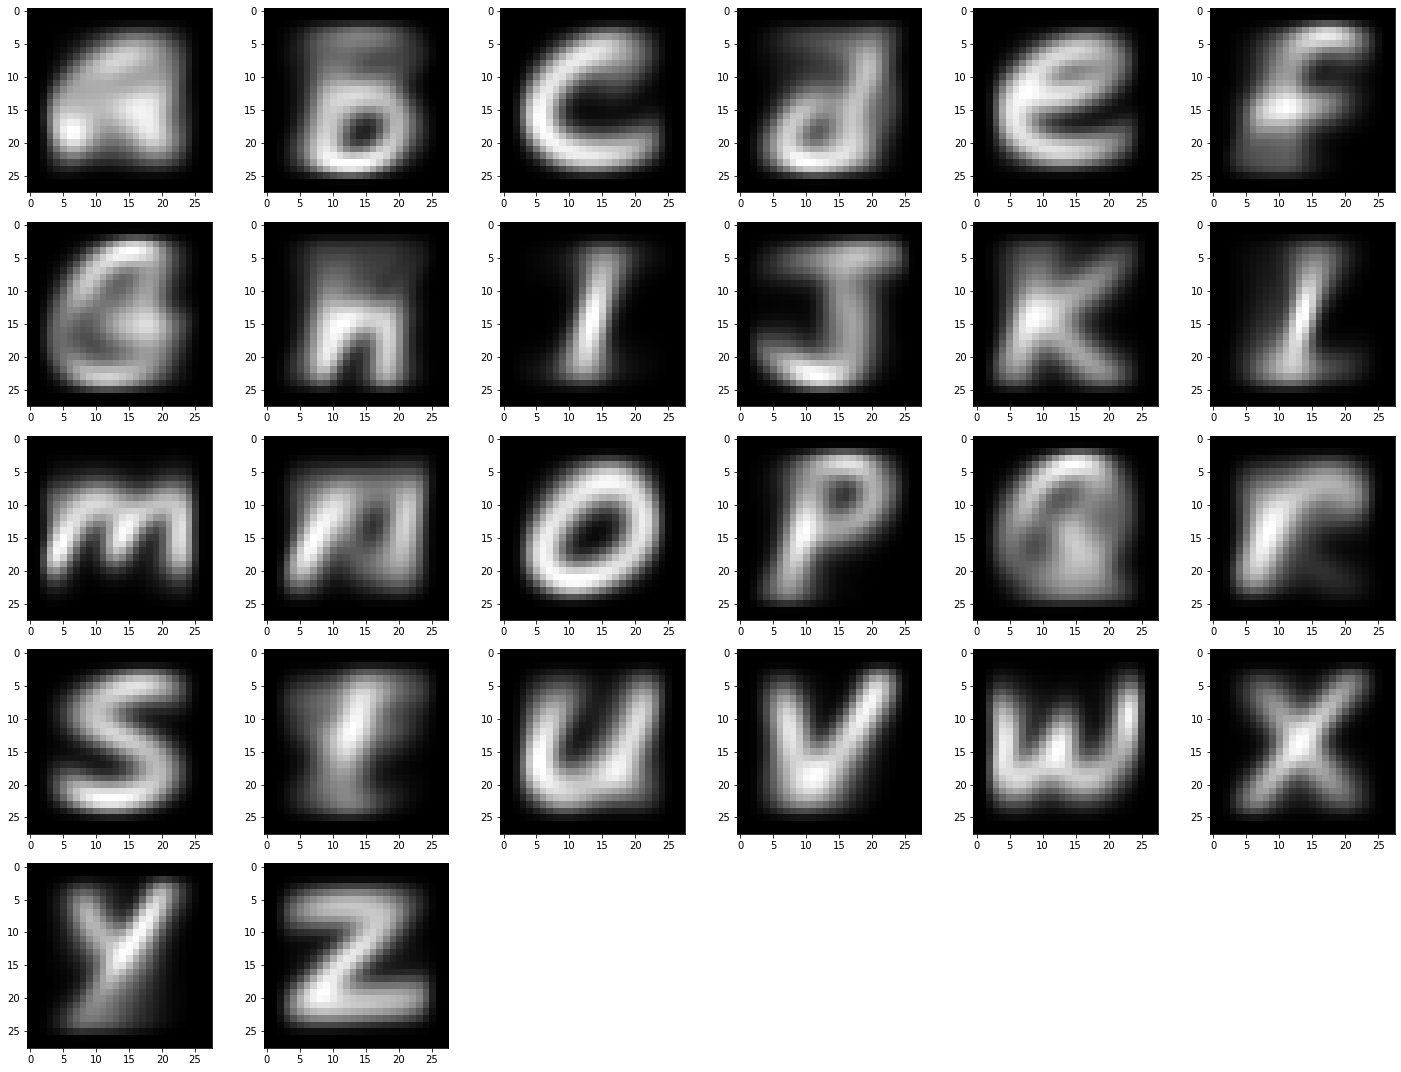

In [31]:
f = plt.figure(figsize=(20, 15))
for i in range(0, 26):
    ax = f.add_subplot(5, 6, i + 1)
    ax.imshow(mean_letters.values[i].reshape(28, 28), cmap='gray')    
plt.tight_layout()

Widać, że w przypadku liter sytuacja jest o wiele gorsza niż w przypadku cyfr. Niektóre litery są całe rozmazane, a więc istnieją duże rozbierzności między charakterem pisma liter, np. A, G, H, N, T, R. Te duże rozbierzności w największej mierze powoduje to, że w zbiorze wmieszane są litery duże i małe, nie przeszkadza to w przypadkach, gdy litera duża i mała są do siebie podbne. Nitkóre z nich są całkiem wyraźne jak np. C, e, J, K, O, v, w, x, z.

In [32]:
dists_letters = euclidean_dist(frame=letters_frame, mean=mean_letters, dataset='letters')
letters_frame['distance'] = dists_letters

In [33]:
letters_frame

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  ...  771  772  773  \
0       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
1       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
2       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
3       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
4       0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
...    .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   
124795  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
124796  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
124797  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
124798  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
124799  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   

        774  775  776  777  778  779  780  781  782  783  label     distance  
0         0    0    0    0    0    0    0    0    0    0      W  2492.498546  
1         0    0    0    0    0    0    0    0    0    0      G  2627.421169  
2         0    0    0    0    0    0    0    0    0    0      P  1730.821481  
3         0    0    0    0    0    0    0    0    0    0      O  2086.990417  
4         0    0    0    0    0    0    0    0    0    0      W  2143.941464  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...          ...  
124795    0    0    0    0    0    0    0    0    0    0      B  2623.837076  
124796    0    0    0    0    0    0    0    0    0    0      R  1909.692907  
124797    0    0    0    0    0    0    0    0    0    0      M  2227.579853  
124798    0    0    0    0    0    0    0    0    0    0      O  2583.870546  
124799    0    0    0    0    0    0    0    0    0    0      S  2297.094904  

[124800 rows x 786 columns]

In [34]:
atypical_letters = letters_frame.sort_values('distance', ascending=False, kind='mergesort').groupby('label').first()
atypical_letters

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  ...  770  771  772  \
label                                                    ...                  
A      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
B      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
C      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
D      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
E      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
F      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
G      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
H      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
I      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
J      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
K      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
L      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
M      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
N      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
O      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
P      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
Q      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
R      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
S      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
T      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
U      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
V      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
W      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
X      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
Y      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   
Z      0  0  0  0  0  0  0  0  0  0   0   0   0   0   0  ...    0    0    0   

       773  774  775  776  777  778  779  780  781  782  783     distance  
label                                                                      
A        0    0    0    0    0    0    0    0    0    0    0  3435.210765  
B        0    0    0    0    0    0    0    0    0    0    0  3442.845335  
C        0    0    0    0    0    0    0    0    0    0    0  3208.264952  
D        0    0    0    0    0    0    0    0    0    0    0  3357.823998  
E        0    0    0    0    0    0    0    0    0    0    0  3405.039060  
F        0    0    0    0    0    0    0    0    0    0    0  3277.685159  
G        0    0    0    0    0    0    0    0    0    0    0  3511.616295  
H        0    0    0    0    0    0    0    0    0    0    0  3391.417993  
I        0    0    0    0    0    0    0    0    0    0    0  3174.409709  
J        0    0    0    0    0    0    0    0    0    0    0  3234.823334  
K        0    0    0    0    0    0    0    0    0    0    0  3143.184373  
L        0    0    0    0    0    0    0    0    0    0    0  3153.398167  
M        0    0    0    0    0    0    0    0    0    0    0  3371.246357  
N        0    0    0    0    0    0    0    0    0    0    0  3478.651032  
O        0    0    0    0    0    0    0    0    0    0    0  3509.763097  
P        0    0    0    0    0    0    0    0    0    0    0  3403.003086  
Q        0    0    0    0    0    0    0    0    0    0    0  3612.879876  
R        0    0    0    0    0    0    0    0    0    0    0  3387.841348  
S        0    0    0    0    0    0    0    0    0    0    0  3379.130066  
T        0    0    0    0    0    0    0    0    0    0    0  3112.723084  
U        0    0    0    0    0    0    0    0    0    0    0  3859.820721  
V        0    0    0    0    0    0    0    0 

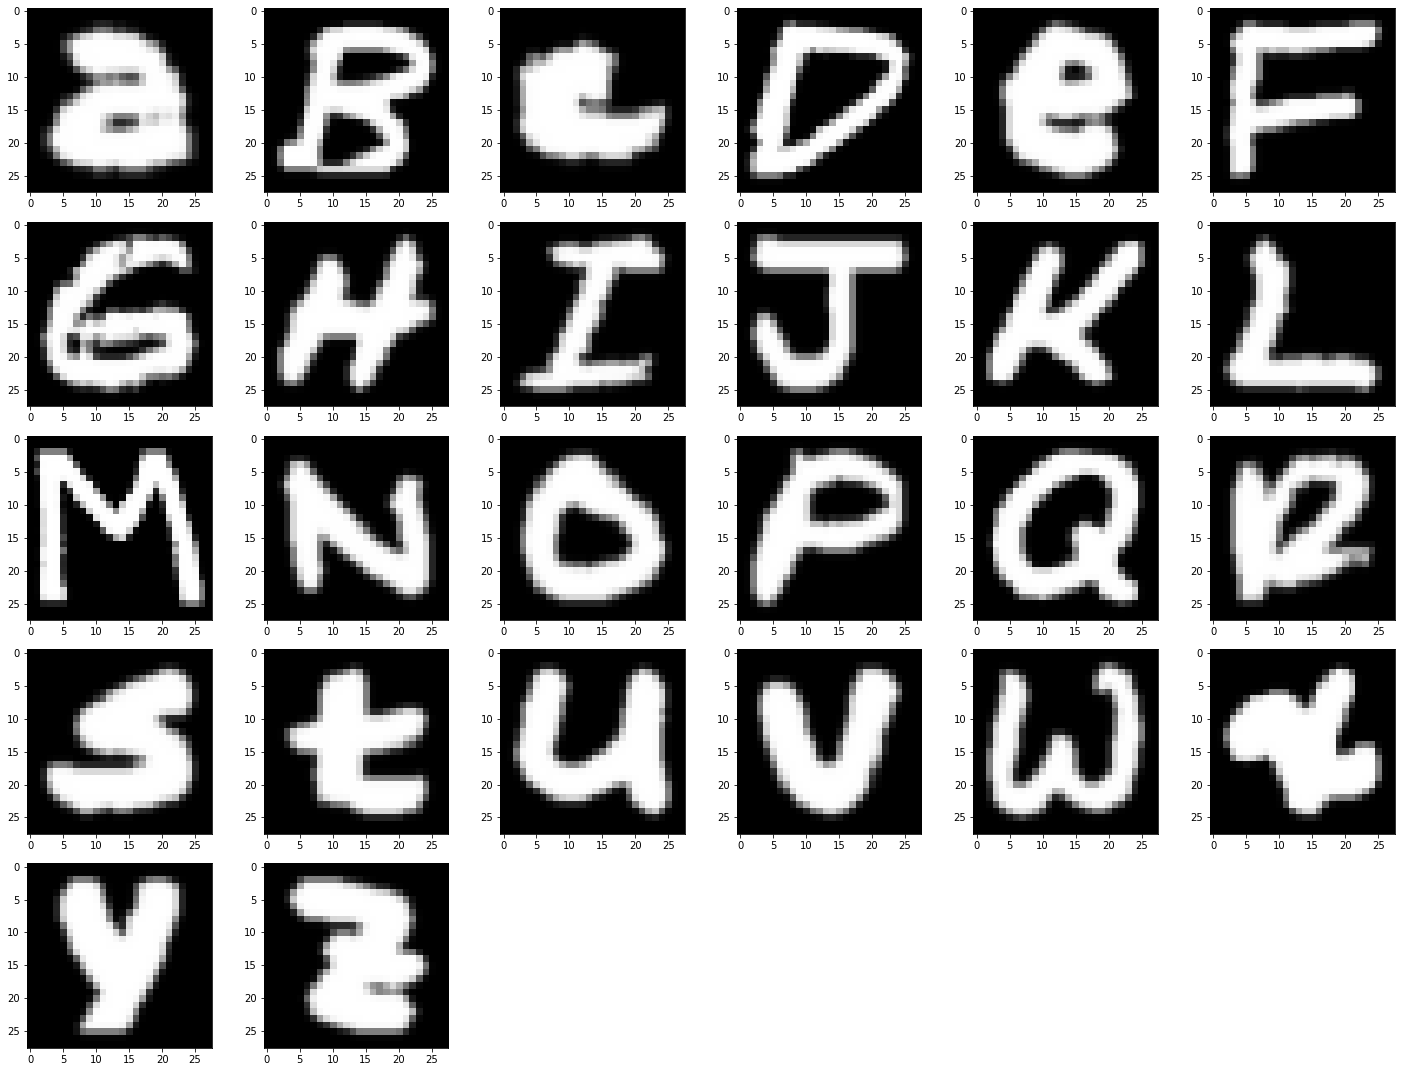

In [35]:
f = plt.figure(figsize=(20, 15))
for i in range(0, 26):
    ax = f.add_subplot(5, 6, i + 1)
    ax.imshow(atypical_letters.values[i][:784].reshape(28, 28), cmap='gray')
plt.tight_layout()

Najbardziej nietypowymi literami są R i x. Pozostałe litery wyglądają na ludzkie oko wyraźnie jednak ich pełny kształt może być utrudnieniem dla algorytmu HOG.

In [36]:
del letters_frame
del mean_letters
del atypical_letters
del dists_letters
gc.collect()
len(gc.get_objects())

224322

### 3.6 Wyniki

In [37]:
hogs = get_hogs(hog_params)

In [38]:
train_letters, train_letters_labels = get_training_samples('letters')
test_letters, test_letters_labels = get_test_samples('letters')

In [39]:
# 6 minutes on average
letters_results = train_test(hogs=hogs, 
                             train_imgs=train_letters, 
                             train_labels=train_letters_labels, 
                             test_imgs=test_letters, 
                             test_labels=test_letters_labels, 
                             ntrees=range(3, 9))

In [40]:
letters_results

block_size  block_stride  nBins  nTrees  accuracy  \
0             4             2      4       3  0.727260   
1             4             2      4       4  0.767452   
2             4             2      4       5  0.793413   
3             4             2      4       6  0.810865   
4             4             2      4       7  0.822981   
..          ...           ...    ...     ...       ...   
103          16            12      9       4  0.774519   
104          16            12      9       5  0.800721   
105          16            12      9       6  0.814760   
106          16            12      9       7  0.822644   
107          16            12      9       8  0.832163   

                                           predictions  
0    [1, 1, 1, 15, 1, 1, 1, 1, 1, 1, 1, 1, 2, 21, 1...  
1    [7, 1, 1, 1, 1, 1, 1, 1, 1, 11, 1, 1, 17, 1, 1...  
2    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14, 1, 15, 1, 1...  
3    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...  
4    [1, 1, 1, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...  
..                                                 ...  
103  [1, 1, 1, 17, 4, 1, 1, 1, 1, 1, 1, 1, 1, 13, 1...  
104  [1, 1, 1, 17, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,...  
105  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 7, 1, 14,...  
106  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 15, 1, 7, 1, 1,...  
107  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  

[108 rows x 6 columns]

Rozpoznawanie liter zdaje się być zdaniem nieco trudniejszym od rozpoznawania cyfr, jednym z czynników na pewno jest mnogość klas, jest ich prawie 3x więcej niż w przypadku cyfr, kolejnym czynnikiem na pewno jest jakość danych, która jest zdecydowanie gorsza.

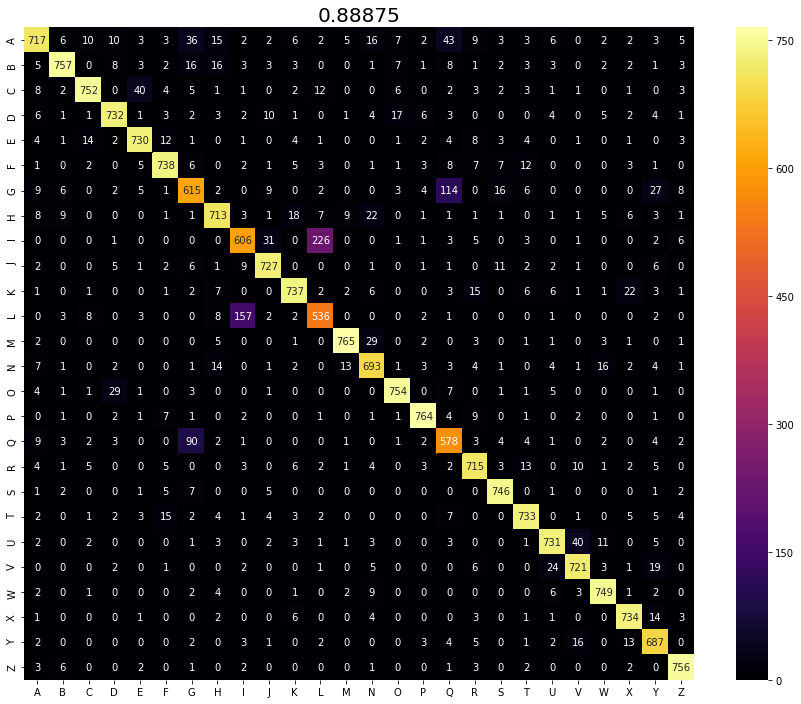

In [41]:
best_letters_model = letters_results.loc[letters_results['accuracy'].idxmax()]
plot_heatmap(rows = best_letters_model.predictions,
             cols = test_letters_labels,
             title = best_letters_model['accuracy'],
             dataset = 'letters')

Model ma największe problemy z poprawną klasyfikacją liter L i Ł, I i L oraz G i Q.

In [42]:
del letters_results
del best_letters_model
del hogs
gc.collect()
len(gc.get_objects())

224513

### 3.7 Eksploracja zbioru Devangari

Obrazy składają się z 784 pikseli (28 x 28). W zbiorze testowym znajduje się 64 400 obserwaji.

In [43]:
devangari_frame = get_training_samples_dataframe('devangari')
devangari_frame

0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
0       0    0    0    0    0    4   18   33   37   40   52   36   12    4   
1       0    0    0    0    0    0    0    0    0    0    0    0   11   68   
2      86  150  211  209  214  214  237  255  255  255  255  255  255  255   
3       8   14    3    0    0    0    0    0    0    0    0    0    0    0   
4       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
64395  93  108   75   51   20    3    0    0    0    2    9    2    0    0   
64396   0    0    0    0    0    0    0    0    0    0    0    0    0    0   
64397   0    0    0    0    0    0    0    0    0    0    0    0    0    0   
64398   0    0    0    0    0    0    0    0    0    0    0    0    0    0   
64399   0    0    0    0    0    0    0    0    0    0    0    0    0    0   

        14  ...  770  771  772  773  774  775  776  777  778  779  780  781  \
0        0  ...    4    4    2    0    0    0    1   56  243  255  255  232   
1      121  ...    0    0    0    1    3    1    0    0    0    0    0    0   
2      255  ...  255   87    0    0    0    0    0    0    0    0    0    0   
3        0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
4        0  ...    0    0    0    0    0    0    0    0    0   40  248  235   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
64395    0  ...   56    3    0    0    0    0    0    0    0    0    0    0   
64396    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
64397    0  ...  255  255  255  255  240  159   44    1    0    0    0    0   
64398    0  ...    2    0    0    0    0    0    0    0    0    0    0    0   
64399    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   

       782  783  label  
0       77   12      3  
1        0    0     23  
2        0    0     11  
3        0    0     17  
4       20    0     41  
...    ...  ...    ...  
64395    0    0     22  
64396    0    0     22  
64397    0    0     39  
64398    0    0     44  
64399    0    0     25  

[64400 rows x 785 columns]

Sytuacja wygląda bardzo podobnie jak w przypadku zbioru liczb i liter, jest wyraźna przewaga pikseli czarnych i białych, wartości pomiędzy jest niewiele. Różnicą jest to, że pikseli białych jest zdecydowanie relatywnie więcej niż w poprzednich zbiorach.

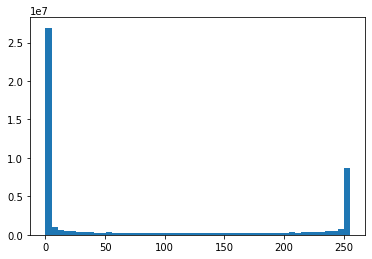

In [44]:
plt.hist(devangari_frame.values[0:64400, 0:784].flatten(), bins=50)
plt.show()

In [45]:
mean_devangari = devangari_frame.groupby('label').mean()
mean_devangari

0          1          2          3          4          5    \
label                                                                     
1       0.028369   0.136879   0.508511   1.033333   1.765957   3.332624   
2       0.761769   1.386591   2.964337   5.537090   8.998573  13.196862   
3       0.532544   1.554734   3.326183   6.361686  11.191568  17.539941   
4       0.848854   2.709169   5.742837   9.850287  15.798711  23.463467   
5      12.579498  18.981172  26.308926  33.297768  39.507671  44.763598   
6      23.304254  34.746215  32.280461  23.685652  20.532084  19.067772   
7       0.108571   0.322857   0.837143   2.566429   5.880000   9.943571   
8      12.638989  17.685199  17.607942  14.888087  14.766787  15.402888   
9      18.629021  24.884203  27.977841  30.042888  31.712652  32.936383   
10      0.000708   0.004958   0.029745   0.121813   0.432720   1.149433   
11     20.395480  27.759887  30.266243  30.985876  30.295904  29.608757   
12      5.976208   7.981255  10.476568  13.626532  17.832733  23.506128   
13      5.139793  13.460059  25.841716  39.529586  48.971154  48.666420   
14      1.282880   2.079353   2.689934   2.409993   1.973549   1.885378   
15     19.769122  24.261331  26.494334  29.223796  31.114023  32.565864   
16      0.439076   0.509804   1.051120   1.907563   3.204482   5.549720   
17     13.336662  18.427247  23.778174  29.868046  35.765335  39.363053   
18      5.879544   8.406985  11.475410  15.374198  18.953671  22.644334   
19      0.430085   0.790960   1.935734   4.574859  10.881356  21.367938   
20     16.345455  21.981119  27.089510  31.904895  36.423077  40.349650   
21     12.994887  16.811541  20.611395  24.097151  26.493791  28.632579   
22      5.157414   9.347857  12.192551  15.626142  18.851019  21.327477   
23      1.017254   1.235802   1.856937   3.110712   4.989935   7.073329   
24     15.270289  19.873453  23.191197  25.854195  28.719395  30.715268   
25      1.382948   1.921243   2.627890   3.038295   3.551301   3.581647   
26      1.978457   6.423211  12.880473  20.143850  25.332870  25.676164   
27     10.614652  18.172894  25.894505  32.567033  38.070330  42.821978   
28      4.647571   7.854967  11.081218  14.567078  17.581581  20.164612   
29      9.556268  14.510684  18.663818  22.470798  27.235043  32.475071   
30      5.635630   8.032991   9.639296  10.088710   9.846041  10.153226   
31     11.252849  16.141738  19.522792  21.967236  25.580484  30.273504   
32      8.285919  10.979271  12.873481  14.516798  16.311651  18.548964   
33      4.340258   6.566619  10.465616  15.568768  20.953438  26.792980   
34     23.960993  30.219149  33.575887  35.829787  37.979433  37.782270   
35      4.545714   6.954286   9.918571  12.632857  15.429286  18.678571   
36     34.196605  39.518388  36.018388  31.657709  29.911598  28.974540   
37     20.119116  25.671184  27.077746  29.663338  32.928673  36.373752   
38     13.803597  18.323741  22.263309  26.710791  30.829496  35.251799   
39     11.104211  16.380443  21.539615  26.377587  32.470378  38.123483   
40      9.447257  14.273558  20.191983  26.016878  31.177918  36.008439   
41      1.269231   5.101140  12.051282  18.907407  24.623932  27.439459   
42     13.912230  20.351799  25.469784  30.072662  34.308633  37.983453   
43      1.784908   1.990127   2.583921   3.879408   5.647391   7.490832   
44      4.091946   6.299359   8.240200   9.835353  11.353528  13.103350   
45     16.029724  26.064402  30.917905  35.229299  39.559802  41.075018   
46      0.155298   0.476052   1.366473   2.169811   2.724238   3.418723   

             6          7          8          9          10         11   \
label                                                                     
1       5.784397   8.799291  13.083688  18.427660  24.351064  29.800709   
2      17.928673  23.653352  30.694009  39.182596  48.818117  58.654066   
3      26.440089  38.353550  50.772929  62.190828  72.093935  78.599852   
4      32.333095  41.364613  50.36103

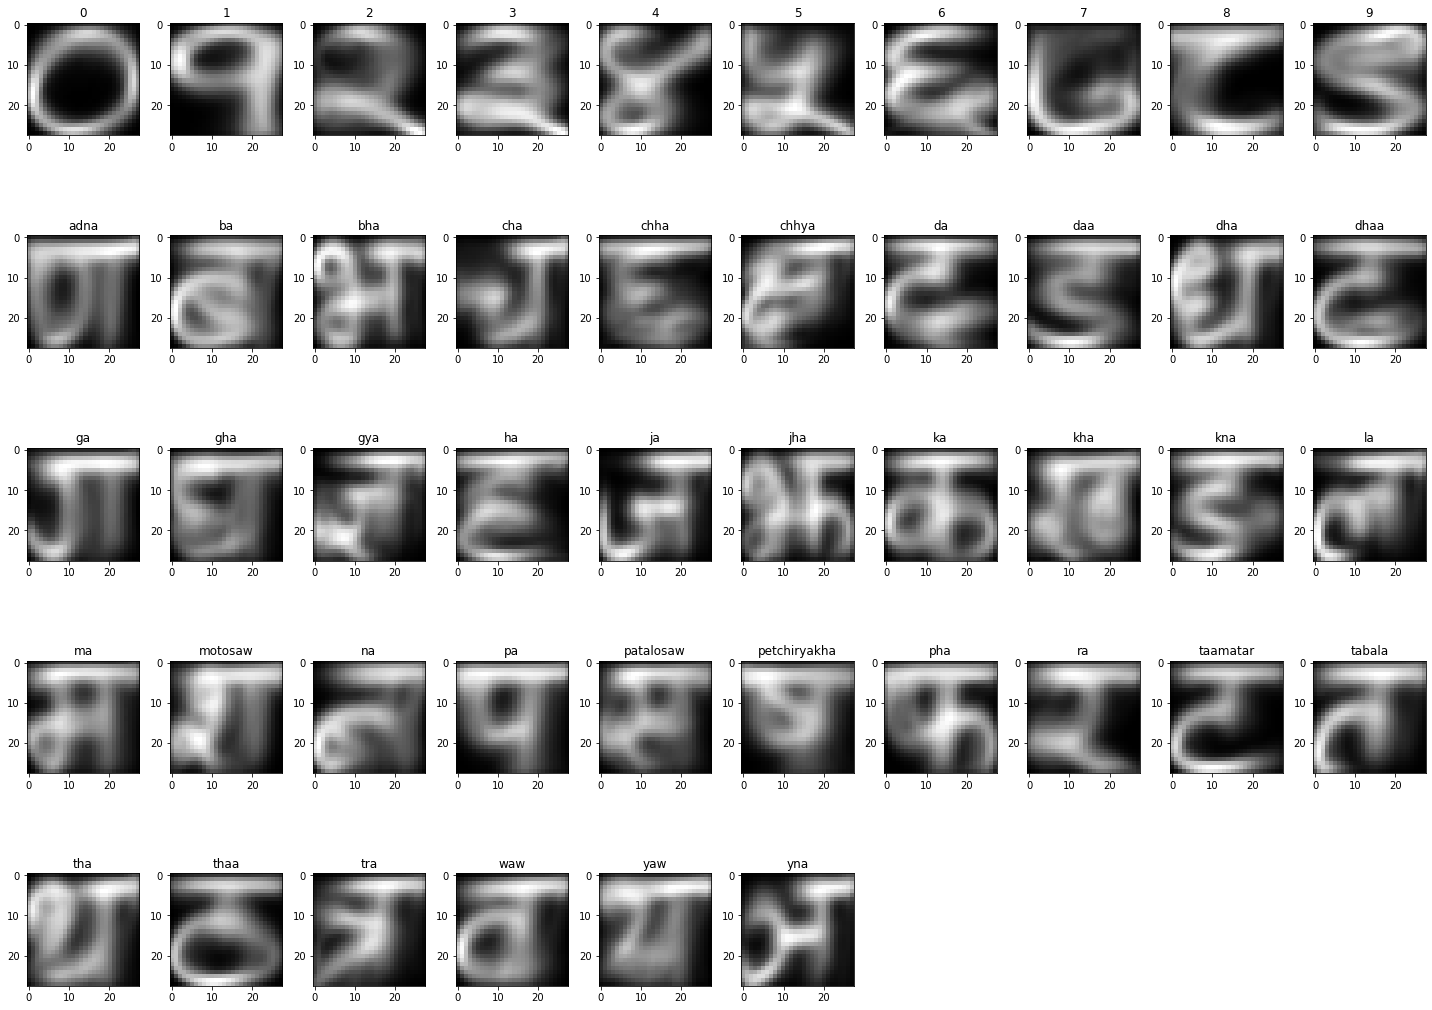

In [46]:
f = plt.figure(figsize=(20, 15))
for i in range(0, 46):
    ax = f.add_subplot(5, 10, i + 1)
    ax.imshow(mean_devangari.values[i].reshape(28, 28), cmap='gray')
    ax.title.set_text(symbols[i + 1])
plt.tight_layout()

Z obrazów powyżej widać, że alfabet devangari ma bardzo skomplikowane symbole. Z tego co jestem w stanie powiedzieć na temat tych elementów to to, że pomimo skomplikowania, sam kształt pokazuje różnice między symbolami w znacznym stopniu, co jest zaletą z perspektywy algorytmu HOG.

In [47]:
dists_devangari = euclidean_dist(frame=devangari_frame, mean=mean_devangari, dataset='devangari')
devangari_frame['distance'] = dists_devangari

In [48]:
devangari_frame

0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
0       0    0    0    0    0    4   18   33   37   40   52   36   12    4   
1       0    0    0    0    0    0    0    0    0    0    0    0   11   68   
2      86  150  211  209  214  214  237  255  255  255  255  255  255  255   
3       8   14    3    0    0    0    0    0    0    0    0    0    0    0   
4       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
64395  93  108   75   51   20    3    0    0    0    2    9    2    0    0   
64396   0    0    0    0    0    0    0    0    0    0    0    0    0    0   
64397   0    0    0    0    0    0    0    0    0    0    0    0    0    0   
64398   0    0    0    0    0    0    0    0    0    0    0    0    0    0   
64399   0    0    0    0    0    0    0    0    0    0    0    0    0    0   

        14  ...  771  772  773  774  775  776  777  778  779  780  781  782  \
0        0  ...    4    2    0    0    0    1   56  243  255  255  232   77   
1      121  ...    0    0    1    3    1    0    0    0    0    0    0    0   
2      255  ...   87    0    0    0    0    0    0    0    0    0    0    0   
3        0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
4        0  ...    0    0    0    0    0    0    0    0   40  248  235   20   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
64395    0  ...    3    0    0    0    0    0    0    0    0    0    0    0   
64396    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
64397    0  ...  255  255  255  240  159   44    1    0    0    0    0    0   
64398    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   
64399    0  ...    0    0    0    0    0    0    0    0    0    0    0    0   

       783  label     distance  
0       12      3  2713.812263  
1        0     23  2478.858003  
2        0     11  2809.223380  
3        0     17  2585.924013  
4        0     41  3134.042916  
...    ...    ...          ...  
64395    0     22  2624.885902  
64396    0     22  2526.568622  
64397    0     39  2627.645524  
64398    0     44  2546.507019  
64399    0     25  2371.760106  

[64400 rows x 786 columns]

In [49]:
atypical_devangari = devangari_frame.sort_values('distance', ascending=False, kind='mergesort').groupby('label').first()
atypical_devangari

0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
label                                                                         
1        0    0    0    0    0    0    0    0    0    0    4   23   77  161   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    2   13   
4        0    0    0    0    0    0    0    0    0    0    0    0    2    8   
5        1    2    2    2    2    1    0    0    0    0    0    0    0    0   
6       14  131  251  189   49    3    0    0    0    0    0    0    0    0   
7        0    0    0    0    0    0    0    0    0    0    0    0    3    8   
8      255  255  255  222  140  108  133  166  151   85   30    6    0    0   
9        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
10       1    5   17   38   79  120  171  212  250  255  255  255  255  255   
11       4   28   55   33   22  126  255  255  240   80    5    0    0    0   
12       0    0    0    0    0    0    0    0    0    0    0    0    0   21   
13       0    0    3   21   62  131  212  255  255  255  213  105   28    5   
14       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
15       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
16       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
17     255  252  204  255  255  255  255  255  255  255  255  254  227  201   
18     255  255  255  255  255  255  255  255  255  255  255  255  255  255   
19       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
20     120  137  169  206  242  255  255  255  255  255  255  255  255  253   
21       0    0    8  153  255  207  127  164  251  255  255  255  255  255   
22     174  133   77   62  115  175  196  191  184  189  189  183  175  174   
23       0    0    0    0    0    0    0    0    0   12   66  197  246  250   
24       0    0    0    0    0    0    0    1    2    3    5    8   15   24   
25       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
26       5   99  248  169   58   76   69   53   33   17   12    6    2    2   
27       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
28       0    0    0    0    0   10  129  140  107   97   91  176  250  255   
29       9   31   69   95  107  126  156  171  160  146  158  176  182  183   
30     226  250  255  255  255  255  255  255  255  255  255  255  255  255   
31     255  255  255  255  255  255  255  255  255  255  255  255  255  255   
32       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
33       0    0    0    0    0    0    0    0    0   38  213  255  253  107   
34     255  255  255  255  255  255  255  255  255  255  255  255  255  255   
35       0    0    0    0    2   69  232  255  238   65    3    1    1    1   
36     255  255  255  255  255  255  255  255  255  255  255  255  255  255   
37      30  169  254  226  228  255  255  255  249  227  255  255  255  255   
38       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
39       4    9   22   43   64   86  111  148  185  220  251  255  255  255   
40     255  255  255  255  255  255  255  255  255  255  255  255  255  255   
41       1    4   19   63  118  146  161  177  191  205  225  235  248  255   
42       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
43       0    2   12   41   84  123  156  184  202  213  227  249  255  255   
44       0    0    0    0    0    0    0    0    0    0    0    0    3   11   
45       0    0    0    0    0    0    0    0    0    0    0    0    0    0   
46       0    2   19   66  149  160   93   49   17    5    1    0    0    0   

        14  ...  770  771  772  773  774  775  776  777  778  779  780  781  \
label       ...                                                               
1      224  ...    0    0    0    0    0    0    0    0   

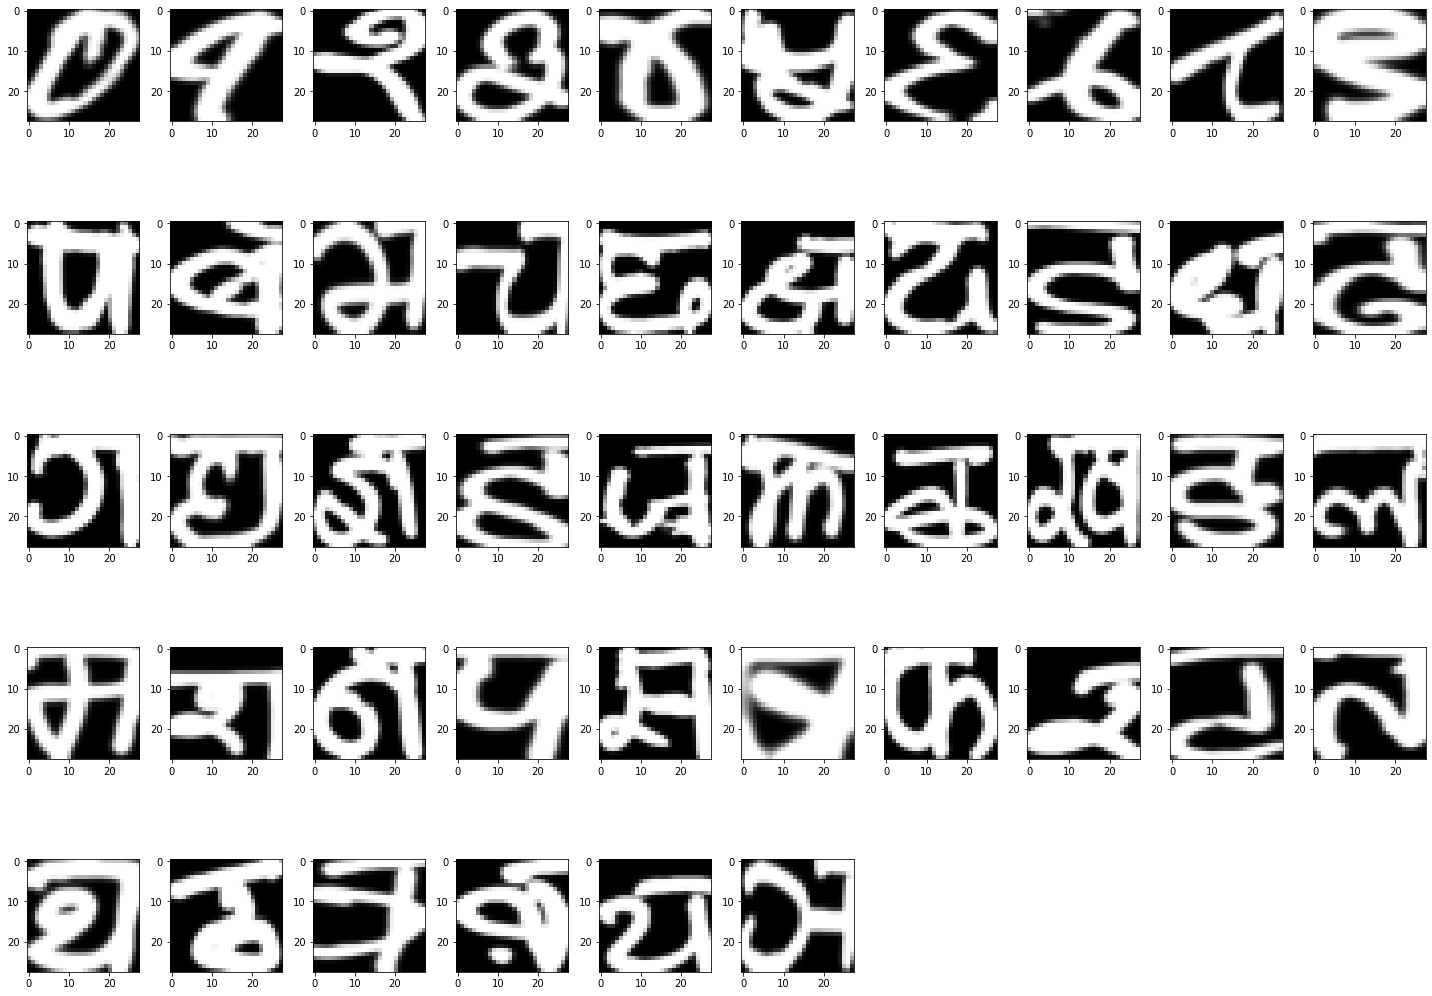

In [50]:
f = plt.figure(figsize=(20, 15))
for i in range(0, 46):
    ax = f.add_subplot(5, 10, i + 1)
    ax.imshow(atypical_devangari.values[i][:784].reshape(28, 28), cmap='gray')
plt.tight_layout()

To co jest bardzo wyraźne to to, że symbole zajmują całą przestrzeń, niektóre wyglądają jak by były ucięte, zdecydowanie alfabet ten sprawia wrażenie trudnego do klasyfikacji.

In [51]:
del devangari_frame
del mean_devangari
del atypical_devangari
del dists_devangari
gc.collect()
len(gc.get_objects())

259853

### 3.8 Wyniki

In [52]:
hogs = get_hogs(hog_params)

In [53]:
# 13 - 15 seconds each function
train_devangari, train_devangari_labels = get_training_samples('devangari')
test_devangari, test_devangari_labels = get_test_samples('devangari')

In [54]:
# 3 minutes 30 seconds on average
devangari_results = train_test(hogs=hogs, 
                               train_imgs=train_devangari, 
                               train_labels=train_devangari_labels, 
                               test_imgs=test_devangari, 
                               test_labels=test_devangari_labels)

In [55]:
devangari_results

block_size  block_stride  nBins  nTrees  accuracy  \
0            4             2      4       1  0.718986   
1            4             2      4       2  0.718116   
2            4             2      4       3  0.813732   
3            4             2      4       4  0.866703   
4            4             2      4       5  0.890362   
5            4             2      9       1  0.758225   
6            4             2      9       2  0.754094   
7            4             2      9       3  0.850254   
8            4             2      9       4  0.894638   
9            4             2      9       5  0.917971   
10           4             3      4       1  0.713696   
11           4             3      4       2  0.717464   
12           4             3      4       3  0.815833   
13           4             3      4       4  0.860362   
14           4             3      4       5  0.885507   
15           4             3      9       1  0.748841   
16           4             3      9       2  0.748732   
17           4             3      9       3  0.843333   
18           4             3      9       4  0.893007   
19           4             3      9       5  0.915978   
20           8             4      4       1  0.725507   
21           8             4      4       2  0.730471   
22           8             4      4       3  0.820725   
23           8             4      4       4  0.865942   
24           8             4      4       5  0.893225   
25           8             4      9       1  0.782681   
26           8             4      9       2  0.778442   
27           8             4      9       3  0.871703   
28           8             4      9       4  0.912754   
29           8             4      9       5  0.935072   
30          10             9      4       1  0.690906   
31          10             9      4       2  0.686630   
32          10             9      4       3  0.782717   
33          10             9      4       4  0.827464   
34          10             9      4       5  0.850978   
35          10             9      9       1  0.769638   
36          10             9      9       2  0.776304   
37          10             9      9       3  0.862391   
38          10             9      9       4  0.905109   
39          10             9      9       5  0.922971   
40          12             4      4       1  0.707428   
41          12             4      4       2  0.714529   
42          12             4      4       3  0.800580   
43          12             4      4       4  0.846413   
44          12             4      4       5  0.874167   
45          12             4      9       1  0.791051   
46          12             4      9       2  0.787790   
47          12             4      9       3  0.876413   
48          12             4      9       4  0.919203   
49          12             4      9       5  0.934565   
50          12             8      4       1  0.668696   
51          12             8      4       2  0.673696   
52          12             8      4       3  0.759964   
53          12             8      4       4  0.804348   
54          12             8      4       5  0.830399   
55          12             8      9       1  0.781957   
56          12             8      9       2  0.777065   
57          12             8      9       3  0.865109   
58          12             8      9       4  0.908696   
59          12             8      9       5  0.928514   
60          14             7      4       1  0.625906   
61          14             7      4       2  0.622826   
62          14             7      4       3  0.703587   
63          14             7      4       4  0.745833   
64          14             7      4       5  0.766848   
65          14             7      9       1  0.776341   
66          14             7      9       2  0.776667   
67          14             7      9       3  0.867536   
68          14             7      9       4  0.902428   
69          14

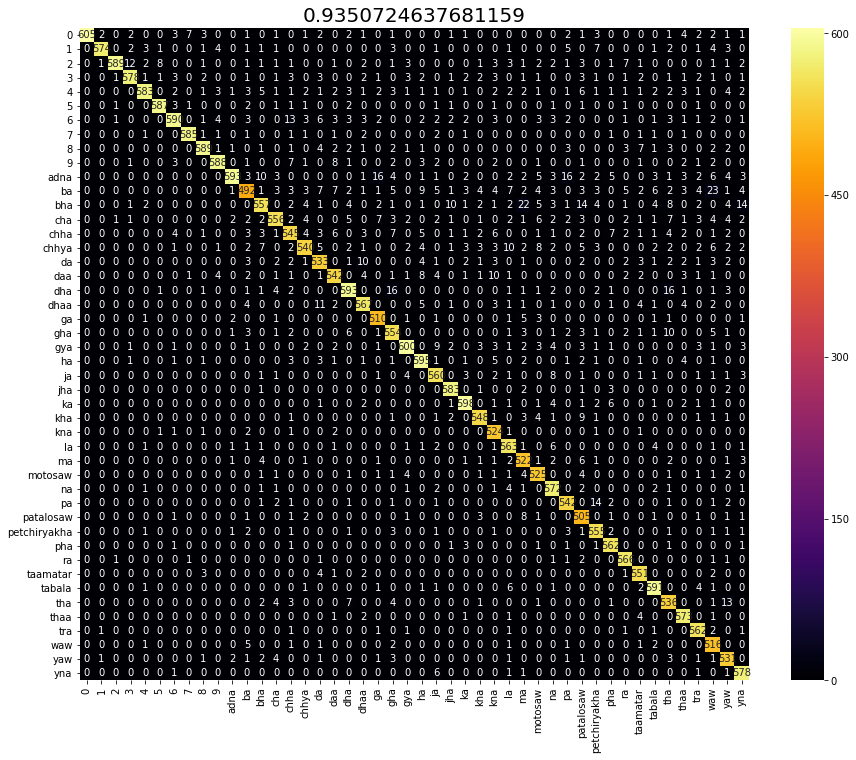

In [56]:
best_devangari_model = devangari_results.loc[devangari_results['accuracy'].idxmax()]
plot_heatmap(rows = best_devangari_model.predictions,
             cols = test_devangari_labels,
             title = best_devangari_model['accuracy'],
             dataset = 'devangari')

Algorytm lasu losowego w połączeniu z cechami HOG zadziałał bardzo dobrze, błąd klasyfikacji jest bardzo mały pomimo 46 klas oraz dość skomplikowanych w zakresie kształtu obserwacji. Dowodzi to temu, że HOG bardzo dobrze opisuje cechę kształtu obiektów w obrazie.

In [57]:
del devangari_results
del best_devangari_model
del hogs
gc.collect()
len(gc.get_objects())

260063